In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time

# Insert path to mavenn beginning of path
import os
import sys
abs_path_to_mavenn = os.path.abspath('../../../')
sys.path.insert(0, abs_path_to_mavenn)

# Load mavenn
import mavenn
print(mavenn.__path__)

['/Users/jkinney/github/mavenn/mavenn']


In [2]:
# Load example data
data_df = mavenn.load_example(which='training_data', name='mpsa')
print(f'training N: {len(data_df)}')

data_df.head()

training N: 16446


,x,y
0,TAAGCTTTA,-3.455265
1,GCAGCCTAT,-3.135494
2,GTGGTAAGG,2.291043
3,TGGGCGCAG,-3.147840
4,GGTGCGGGC,0.547527


In [3]:
# Set seeed
mavenn.set_seed(0)

# Define model
model = mavenn.Model(regression_type='GE',
                     L=len(data_df['x'][0]),
                     alphabet='dna',
                     gpmap_type='pairwise',                     
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)


In [4]:
# Set training data
model.set_data(x=data_df['x'],
               y=data_df['y'],
               shuffle=True)

N = 16,446 observations set as training data.
Data shuffled.
Time to set data: 0.0629 sec.


In [5]:
# Fit model to data
history = model.fit(learning_rate=.001,
                    epochs=1000,
                    batch_size=1000,
                    early_stopping=True,
                    early_stopping_patience=30)

 
LSMR            Least-squares solution of  Ax = b

The matrix A has    16446 rows  and       36 cols
damp = 0.00000000000000e+00

atol = 1.00e-06                 conlim = 1.00e+08

btol = 1.00e-06             maxiter =       36

 
   itn      x(1)       norm r    norm Ar  compatible   LS      norm A   cond A
     0  0.00000e+00  1.282e+02  4.124e+03   1.0e+00  2.5e-01
     1  2.21759e-02  1.158e+02  1.332e+03   9.0e-01  1.5e-01  7.4e+01  1.0e+00
     2  3.11979e-02  1.142e+02  2.344e+02   8.9e-01  1.9e-02  1.1e+02  1.1e+00
     3  3.17511e-02  1.142e+02  1.944e+02   8.9e-01  1.3e-02  1.4e+02  1.1e+00
     4  3.21405e-02  1.141e+02  4.639e+01   8.9e-01  1.5e-03  2.7e+02  1.8e+00
     5  3.30620e-02  1.141e+02  1.069e+01   8.9e-01  3.4e-04  2.7e+02  2.4e+00
     6  3.33971e-02  1.141e+02  1.356e+00   8.9e-01  4.2e-05  2.8e+02  2.4e+00
     7  3.33400e-02  1.141e+02  2.131e-01   8.9e-01  6.5e-06  2.9e+02  2.4e+00
     8  3.33309e-02  1.141e+02  6.560e-02   8.9e-01  2.0e-06  2.9e+02  2.4

14/14 [==============================] - 0s 9ms/step - loss: 772.9918 - val_loss: 776.2709
Epoch 66/1000
14/14 [==============================] - 0s 9ms/step - loss: 769.1819 - val_loss: 775.0853
Epoch 67/1000
14/14 [==============================] - 0s 9ms/step - loss: 764.2736 - val_loss: 772.3046
Epoch 68/1000
14/14 [==============================] - 0s 8ms/step - loss: 764.0991 - val_loss: 769.4543
Epoch 69/1000
14/14 [==============================] - 0s 9ms/step - loss: 760.9996 - val_loss: 766.8304
Epoch 70/1000
14/14 [==============================] - 0s 8ms/step - loss: 758.5084 - val_loss: 768.2405
Epoch 71/1000
14/14 [==============================] - 0s 8ms/step - loss: 758.3915 - val_loss: 767.4863
Epoch 72/1000
14/14 [==============================] - 0s 9ms/step - loss: 756.1224 - val_loss: 763.9231
Epoch 73/1000
14/14 [==============================] - 0s 9ms/step - loss: 753.5552 - val_loss: 762.5242
Epoch 74/1000
14/14 [==============================] - 0s 9ms/step - 

14/14 [==============================] - 0s 10ms/step - loss: 712.2087 - val_loss: 733.2419
Epoch 143/1000
14/14 [==============================] - 0s 10ms/step - loss: 709.1048 - val_loss: 733.5240
Epoch 144/1000
14/14 [==============================] - 0s 10ms/step - loss: 708.6164 - val_loss: 733.6740
Epoch 145/1000
14/14 [==============================] - 0s 10ms/step - loss: 710.2637 - val_loss: 733.9055
Epoch 146/1000
14/14 [==============================] - 0s 9ms/step - loss: 708.2076 - val_loss: 733.0425
Epoch 147/1000
14/14 [==============================] - 0s 11ms/step - loss: 708.3767 - val_loss: 732.8267
Epoch 148/1000
14/14 [==============================] - 0s 11ms/step - loss: 708.7344 - val_loss: 733.4879
Epoch 149/1000
14/14 [==============================] - 0s 11ms/step - loss: 708.9047 - val_loss: 731.6681
Epoch 150/1000
14/14 [==============================] - 0s 11ms/step - loss: 708.5346 - val_loss: 732.7574
Epoch 151/1000
14/14 [==============================]

14/14 [==============================] - 0s 10ms/step - loss: 679.8918 - val_loss: 708.9846
Epoch 219/1000
14/14 [==============================] - 0s 9ms/step - loss: 679.3947 - val_loss: 707.6415
Epoch 220/1000
14/14 [==============================] - 0s 9ms/step - loss: 679.0233 - val_loss: 707.0081
Epoch 221/1000
14/14 [==============================] - 0s 10ms/step - loss: 676.9275 - val_loss: 706.4041
Epoch 222/1000
14/14 [==============================] - 0s 9ms/step - loss: 677.5406 - val_loss: 705.2773
Epoch 223/1000
14/14 [==============================] - 0s 9ms/step - loss: 677.4347 - val_loss: 703.9424
Epoch 224/1000
14/14 [==============================] - 0s 9ms/step - loss: 677.1042 - val_loss: 703.8629
Epoch 225/1000
14/14 [==============================] - 0s 9ms/step - loss: 676.4627 - val_loss: 715.3654
Epoch 226/1000
14/14 [==============================] - 0s 9ms/step - loss: 676.1456 - val_loss: 709.1042
Epoch 227/1000
14/14 [==============================] - 0s 

In [6]:
# Save model
model.save('mpsa_ge_pairwise')

Model saved to these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [7]:
# Load model
model = mavenn.load('mpsa_ge_pairwise')

Model loaded from these files:
	mpsa_ge_pairwise.pickle
	mpsa_ge_pairwise.h5


In [8]:
# Load test data
test_df = mavenn.load_example(which='test_data',name='mpsa')
N_test = len(test_df)
print(f'test data N: {N_test:,}')

# Subsample indices for easy plotting
ix = np.random.rand(N_test) < 1

# Get x and y
x_test = test_df['x'].values[ix]
y_test = test_df['y'].values[ix]

test data N: 5,483


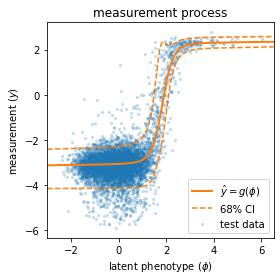

In [9]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

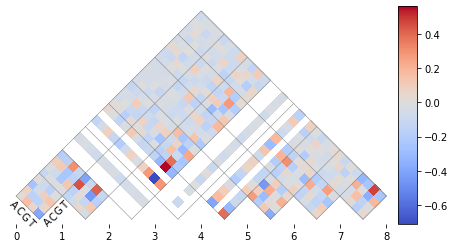

In [10]:
# Plot pairwise parameters
theta_dict = model.get_theta(gauge="uniform")
fig, ax = plt.subplots(1, 1, figsize=[8, 4])
mavenn.heatmap_pairwise(theta_dict['theta_lclc'], 
                        alphabet=theta_dict['alphabet'],
                        ax=ax);